In [1]:
import sys
import time
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.preprocessing.image import ImageDataGenerator


In [2]:
print(os.listdir('../input/image-bike/'))
print(os.listdir('../input/csv-url'))

['data']
['model.csv', 'label.csv', 'data.csv']


In [3]:
url_path = '../input/csv-url/data.csv'
model_path = '../input/csv-url/model.csv'
model_name = pd.read_csv(model_path)
print(model_name.head())
url_image = pd.read_csv(url_path)
print(url_image.head())

   id  brand_id             model
0   1         1  Crossroads Sport
1   2         1               P.3
2   3         1          Langster
3   4         1            Sirrus
4   5         1       Allez Elite
         brand             model             type  year  \
0  Specialized          Langster  URBAN & FITNESS  2018   
1  Specialized  Crossroads Sport  URBAN & FITNESS  2019   
2  Specialized          Langster  URBAN & FITNESS  2018   
3  Specialized          Langster  URBAN & FITNESS  2018   
4  Specialized  Crossroads Sport  URBAN & FITNESS  2019   

                                           image_url  
0  data/e1c73d4ffaaee84ad4acb79aaff9fe80d787c258.jpg  
1  data/8b4a219f4f54e76bebf88f18f0649ce259eef362.jpg  
2  data/27d080b48275bfeb7847b64e8fe71ea68855d70c.jpg  
3  data/685ab5a8265d45896a3a4b1e728353cf2a5059cd.jpg  
4  data/1076ee5278fd873af82d1eac2fc51e48f0e7461e.jpg  


In [4]:
array_model = np.array([model_name["brand_id"], model_name["model"]])
models = []
for i in range(0, len(array_model[1]) - 1):
    if array_model[0][i] == 1:
        models.append(array_model[1][i])
        print(array_model[1][i])
models.remove('Crosstrail Sport')
models.remove('Crossroads')
models.remove('Crossroads Elite')
models.remove('Langster')
models.remove('Stumpjumper FSR Comp 29er')

Crossroads Sport
P.3
Langster
Sirrus
Allez Elite
Crosstrail Sport
Demo 8 I
Crossroads Elite
Crossroads
Stumpjumper FSR Comp 29er


In [5]:
print(models)

['Crossroads Sport', 'P.3', 'Sirrus', 'Allez Elite', 'Demo 8 I']


In [6]:
one_host = np.zeros(len(models))
print(one_host)
one_host[1] = 1 
print(one_host)

[0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]


In [7]:
# apppend url
base_path = '../input/image-bike'
array_list = np.array([url_image["brand"], url_image["model"], url_image["type"], url_image["year"], url_image["image_url"]])
full_path = [os.path.join(base_path, file_name) for file_name in array_list[4]]
print(np.shape(array_list))
print(np.shape(full_path))
print(type(array_list))

(5, 74994)
(74994,)
<class 'numpy.ndarray'>


(224, 224, 3)
(0,)


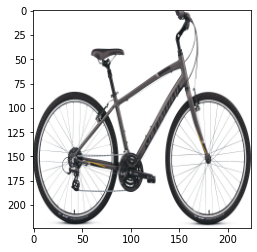

In [8]:
# read image and resize image
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
images = []
brands = array_list[0] 
img_width, img_height, channels= 224, 224, 3
dim = (img_width, img_height)
resized_images = []
label_images = [] 
for i in range(0, len(brands)):
    if brands[i] == "Specialized":
        name = full_path[i]
        image = cv2.imread(name, cv2.IMREAD_UNCHANGED)
        one_host = np.zeros(len(models))
        for j in range(0, len(models)) :
            if array_list[1][i] == models[j]:
                if image is not None and np.shape(image)[0] >= 224 and np.shape(image)[1] >= 224 and np.shape(image)[2] == 3:
                    image_resize = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
                    resized_images.append(image_resize)
                    one_host[j] = 1
                    label_images.append(one_host)
                elif image is not None and np.shape(image)[2] == 3 :
                    image_resize = cv2.resize(image, dim, interpolation = cv2.INTER_CUBIC)
                    resized_images.append(image_resize)
                    one_host[j] = 1
                    label_images.append(one_host)
print(resized_images[0].shape)
plt.imshow(resized_images[0])
print(np.shape(images))

In [9]:
print(len(resized_images))
print(len(label_images))

9587
9587


In [10]:
for i in resized_images:
    if np.shape(i)[0] < 224 or np.shape(i)[1] < 224:
        print('a')

In [11]:
seed = 100
np.random.seed(seed)
np.random.shuffle(resized_images)
np.random.seed(seed)
np.random.shuffle(label_images)

In [12]:
train_images = np.array(resized_images[:8000])
val_images = np.array(resized_images[8000:])
del resized_images
train_labels = np.array(label_images[:8000])
val_labels = np.array(label_images[8000:])
del label_images
train_data = train_images.astype('float32')
val_data = val_images.astype('float32')

In [13]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [14]:
batch_size = 64

In [15]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [16]:
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
vgg19_model = VGG19()

model = Sequential()
for layer in vgg19_model.layers:
    model.add(layer)
    #print(layer.name)
model.layers.pop()
for layer in model.layers:
    layer.trainable = False
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(models), activation='softmax'))
model.compile(Adam(lr=.00015), loss='categorical_crossentropy', metrics=['accuracy'])
for layer in model.layers: 
    print(layer.name)

574717952/574710816 [==============================] - 3s 0us/step
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions
batch_normalization
dense
batch_normalization_1
dense_1
batch_normalization_2
dense_2


In [17]:
start = time.time()

model_scratch_info = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 250 # images 8000 = steps * batch_size = 250 * 32 
    epochs=22,
    validation_steps=len(val_data)/batch_size, # -> 49 # images 832 = steps * batch_size = 49 * 32
    validation_data=val_generator,
    verbose=1
)

end = time.time()
duration = end - start

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/22
125/125 [==============================] - 104s 741ms/step - loss: 1.6314 - accuracy: 0.3914 - val_loss: 1.7537 - val_accuracy: 0.1865
Epoch 2/22
125/125 [==============================] - 88s 703ms/step - loss: 1.1501 - accuracy: 0.5454 - val_loss: 2.0043 - val_accuracy: 0.1865
Epoch 3/22
125/125 [==============================] - 87s 698ms/step - loss: 1.0757 - accuracy: 0.5722 - val_loss: 1.9806 - val_accuracy: 0.1865
Epoch 4/22
125/125 [==============================] - 88s 701ms/step - loss: 1.0014 - accuracy: 0.6033 - val_loss: 1.7894 - val_accuracy: 0.1947
Epoch 5/22
125/125 [==============================] - 88s 699ms/step - loss: 0.9830 - accuracy: 0.6159 - val_loss: 1.2627 - val_accuracy: 0.4127
Epoch 6/22
125/125 [==============================] - 87s 696ms/step - loss: 0.9502 - accuracy: 0.6310 - val_loss: 1.0390 - val_accuracy: 0.6068
Epoch 7/22
125/125 [==============================] - 89s 707ms/step - loss: 0.9206 - accuracy: 0.6410 - val_loss: 1.0128 - val_a

In [18]:
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, 30) )


 model_scratch took 1958.46 seconds (32.6 minutes) to train for 30 epochs


In [19]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [20]:
def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['accuracy'])), history['accuracy'], 'r')
  plt.plot(np.arange(1, len(history['val_accuracy'])+1), history['val_accuracy'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

model_scratch


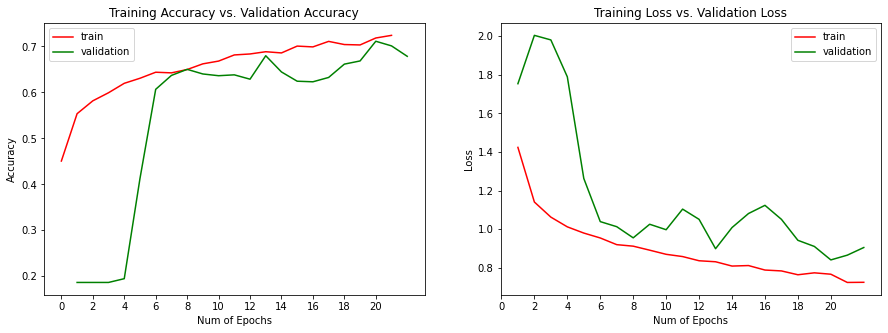

In [21]:
plot_model_history('model_scratch', model_scratch_info.history, 20)

In [22]:
def predict_one_image(img, model):
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)


P.3 97%


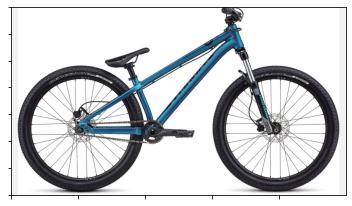

In [23]:
test_img = cv2.imread('../input/image-bike/data/fc4bc7792b6d284393148d1dfbc02feb5ba34002.jpg')
pred, probability = predict_one_image(test_img, model)
print('%s %d%%' % (models[pred], round(probability, 10) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(False)
plt.show()

Allez Elite 71%


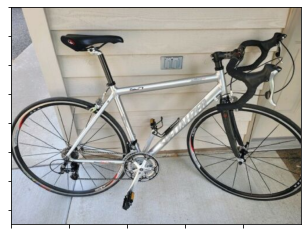

In [24]:
test_img = cv2.imread('../input/test-image/s-l500.jpg')
pred, probability = predict_one_image(test_img, model)
print('%s %d%%' % (models[pred], round(probability, 10) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(False)
plt.show()

In [25]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

Model trained from scatch


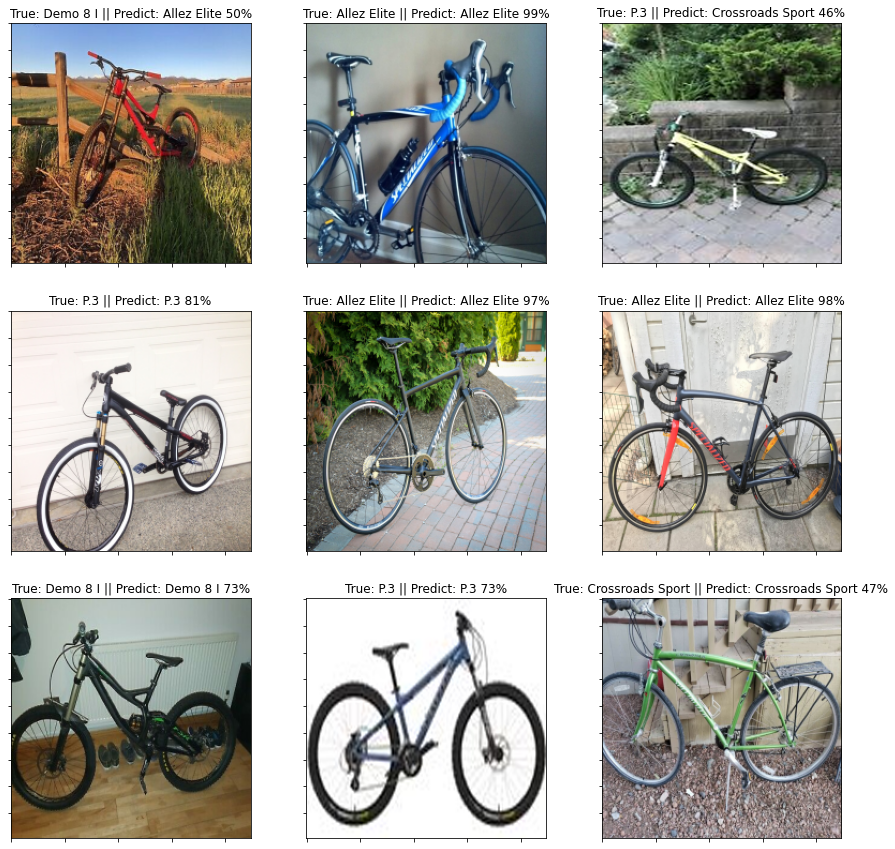

In [26]:
print("Model trained from scatch")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model)
  plt.title('True: %s || Predict: %s %d%%' % (models[category_idx], models[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [27]:
# #save model
# from keras.models import model_from_json

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
    
# save weights to HDF5
model.save("model.h5")
print("Saved model to disk")

Saved model to disk
